# 1. Get the file and preprocess the data

In [1]:
!wget https://raw.githubusercontent.com/tasdikrahman/datasets/master/email/csv/spam-apache.csv

--2019-10-10 21:02:26--  https://raw.githubusercontent.com/tasdikrahman/datasets/master/email/csv/spam-apache.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 366506 (358K) [text/plain]
Saving to: ‘spam-apache.csv’

spam-apache.csv     100%[===================>] 357.92K  --.-KB/s    in 0.03s   

2019-10-10 21:02:26 (11.9 MB/s) - ‘spam-apache.csv’ saved [366506/366506]



In [0]:
import pandas as pd
import numpy as np
import math

### Randomly shuffle the data array, then get 80% for training and the remaining 20% for testing. Next, build the training and testing collections


In [0]:
df = pd.read_csv('spam-apache.csv')
data = df.values

In [0]:
ham = data[data[:, 0] == 1, 1]
spam = data[data[:, 0] == -1, 1]

In [0]:
#shuffles the data set passed in, then creates the test and training sets using the train_size value to decide how much to split
def get_train_test(data, train_size):
  np.random.shuffle(data)
  index = math.floor(data.shape[0] * train_size)
  train = data[:index, :]
  test = data[index:, :]

  return train, test

####################################################################################

#returns 4 items, the training emails, training class, and test emails/class
def get_xy_train_test(train, test):
  x_train = train[:, 1]
  y_train = train[:, 0]

  x_test = test[:, 1]
  y_test = test[:, 0]

  return x_train, y_train, x_test, y_test

#####################################################################################

#returns 5 values, a dict with the number of occurences of all words in the training emails, a dict with the probability that the word
#occurs in a ham email, a dict with the prob in spam emails, and the overall class probability for ham and spam (all built using the two arrays passed in, intended to be the training data)
def get_dict(x_train, y_train):
  master_words = {}
  ham_words = {}
  spam_words = {}

  for i in range(0, x_train.size):
    email = x_train[i].split(' ')
    for ix in range(0, len(email)):
      master_words.update({email[ix]: 0})

  ham_words.update(master_words)
  spam_words.update(master_words)

  ham_emails = x_train[y_train==1]
  spam_emails = x_train[y_train==-1]

  for word in master_words:
    for i in range(0, ham_emails.size):
      if word in ham_emails[i]:
        master_words[word] += 1
        ham_words[word] += 1
    for i in range(0, spam_emails.size):
      if word in spam_emails[i]:
        master_words[word] += 1
        spam_words[word] += 1

  for word in master_words:
    ham_words[word] = ham_words[word] / master_words[word]
    spam_words[word] = spam_words[word] / master_words[word]

  hguess_train = ham_emails.size / x_train.size
  sguess_train = spam_emails.size / x_train.size

  return master_words, ham_words, spam_words, hguess_train, sguess_train

In [0]:
train, test = get_train_test(data, .8)

x_train, y_train, x_test, y_test = get_xy_train_test(train, test)

master_words, ham_words, spam_words, hguess_train, sguess_train = get_dict(x_train, y_train)

# 2. Run the testing set

### These functions are all that need to be used for section 2, those being
-get_words_begin

-get_words_end

-get_class

-get_accuracy

-solve

In [0]:
#returns a list of words from the list passed in, using size to determine the percentage to include starting from the front of the list
def get_words_begin(size, words):
  index = math.floor(len(words) * size)
  new_words = words[:index+1]

  return new_words

#################################################################################################

#returns a list of words from the list passed in, using the size to determine the percentage to include starting from the end (last 10%, 20%, ...)
def get_words_end(size, words):
  index = math.floor(len(words) * size)
  new_words = words[len(words) - index:]

  return new_words

#################################################################################################

#takes in 4 values, comparing the first two to decide class. in the event they are perfectly equal then only uses the second two values
#return 1 for ham, -1 for spam
def get_class(ham_prob, spam_prob, hguess_train, sguess_train):
  eclass = 0

  if ham_prob > spam_prob:
    eclass = 1
  elif spam_prob > ham_prob:
    eclass = -1
  else:
    if hguess_train > sguess_train:
      eclass = 1
    else:
      eclass = -1

  return eclass

####################################################################################################

#compares the predicted classification and actual classification to determines which accuracy value needs to change
def get_accuracy(accuracy, pred, actual):
    if pred == 1 and actual == 1:
      accuracy[0,0] += 1
    elif pred == -1 and actual == 1:
      accuracy[0, 1] += 1
    elif pred == -1 and actual == -1:
      accuracy[1, 1] += 1
    else:
      accuracy[1, 0] += 1

##################################################################

#returns an accuracy matrix using the size and type passed in, along with the main arrays needed
# type determines how to get the words by which the email is classified, accepting "begin", "end", and "all"
# first row denotes ham emails, second denotes spam, 1st column denotes correct match, 2nd column denotes mismatch
def solve(size, type, hwords, swords, hguess_train, sguess_train, x_test, y_test):
  accuracy = np.array([[0, 0], 
                      [0, 0]])

  cguess = 0
  iguess = 0

  for i in range(0, x_test.size):

    ham_prob = 1
    spam_prob = 1
    eclass = 0

    if type == 'begin':
      words = get_words_begin(size, x_test[i].split(' '))
    elif type == 'end':
      words = get_words_end(size, x_test[i].split(' '))
    elif type == 'all':
      words = x_test[i].split(' ')

    for word in words:
      try:
        hprob_word = hwords[word]
        sprob_word = swords[word]

        if hprob_word == 0:
          hprob_word = 1
        if sprob_word == 0:
          sprob_word = 1

        ham_prob *= hprob_word
        spam_prob *= sprob_word

      except KeyError:
        continue

    ham_prob *= hguess_train
    spam_prob *= sguess_train

    eclass = get_class(ham_prob, spam_prob, hguess_train, sguess_train)

    get_accuracy(accuracy, eclass, y_test[i])

  return accuracy


## 2.1 First sets of words (10/20/30/40/50/60/70/80/90)


In [0]:
results = {}
for i in range(10, 100, 10):
  results.update({'first' + str(i): solve(i/100, 'begin', ham_words, spam_words, hguess_train, sguess_train, x_test, y_test)})

## 2.2 Last set of words (10/20/30/40/50/60/70/80/90%)

In [0]:
for i in range(10, 100, 10):
  results.update({'last' + str(i): solve(i/100, 'end', ham_words, spam_words, hguess_train, sguess_train, x_test, y_test)})

## 2.3 All words in the email

In [0]:
results.update({'all': solve(100, 'all', ham_words, spam_words, hguess_train, sguess_train, x_test, y_test)})

In [11]:
for word in results: 
  print(word, ' \n', results[word])

first10  
 [[24  3]
 [ 4 19]]
first20  
 [[24  3]
 [ 0 23]]
first30  
 [[23  4]
 [ 0 23]]
first40  
 [[23  4]
 [ 0 23]]
first50  
 [[23  4]
 [ 0 23]]
first60  
 [[23  4]
 [ 1 22]]
first70  
 [[22  5]
 [ 1 22]]
first80  
 [[22  5]
 [ 1 22]]
first90  
 [[22  5]
 [ 1 22]]
last10  
 [[18  9]
 [ 0 23]]
last20  
 [[19  8]
 [ 1 22]]
last30  
 [[20  7]
 [ 1 22]]
last40  
 [[20  7]
 [ 1 22]]
last50  
 [[21  6]
 [ 1 22]]
last60  
 [[21  6]
 [ 1 22]]
last70  
 [[21  6]
 [ 1 22]]
last80  
 [[23  4]
 [ 1 22]]
last90  
 [[23  4]
 [ 1 22]]
all  
 [[23  4]
 [ 1 22]]


## 3. Analysis

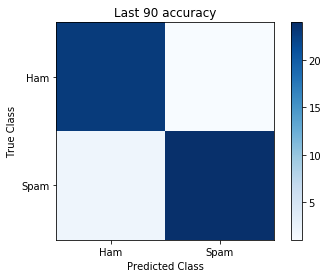

In [0]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
pos = ax1.imshow(results['last90'], cmap='Blues', interpolation='none')
class_names = ['Ham', 'Spam']
plt.title('Last 90 accuracy')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
fig.colorbar(pos, ax=ax1)